# Sentiment Analysis Using Bi-LSTM

In [74]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [78]:
dataset=pd.read_csv('Uber_Dataset1.csv')

In [79]:
dataset.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis,label
0,0,Some very good simulations of bus v car can b...,0.780,0.910,Positive,1
1,1,the all time greatest price and rates ever...,0.875,0.900,Positive,1
2,2,Your services at Bengaluru Airport is so scre...,0.600,0.700,Positive,1
3,3,Lots of good analysis on Uber IPO in the shar...,0.625,0.675,Positive,1
4,4,Seeing this I didnt book any ride from you w...,0.700,0.600,Positive,1


In [80]:
#Removing the unnecessary columns.
dataset = dataset[['label','tweet']]

# Replacing the values.
dataset['tweet'] = dataset['tweet'].replace(4,1)

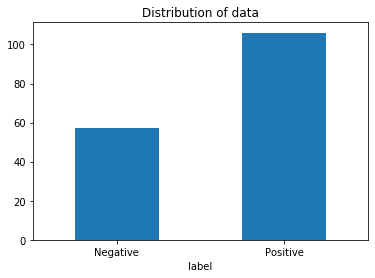

In [81]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [82]:
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    weet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [83]:
%%time
dataset['processed_text'] = dataset.tweet.apply(preprocess_apply)

Wall time: 15 ms


In [88]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break
processedtext = list(dataset['processed_text'])
data_pos = processedtext[:263]
data_neg = processedtext[263:]

Text:  Some very good simulations of bus v car can be done with uber pool  even when competing with bus  th price
Processed:  some very good simulations of bus v car can be done with uber pool  even when competing with bus  th price
Text:     the all time greatest price and rates ever been paid by any of company great working with uber ₹  for trip Shame on you guys  httpstcoFwsemKUEWZ
Processed:   the all time greatest price and rates ever been paid by any of company great working with uber    for trip shame on you guys  httpstcofwsemkuewz
Text:  Your services at Bengaluru Airport is so screwed up The cab drivers keep canceling the request to increase the price Support staff is good for nothing Has been happening for months now
Processed:  your services at bengaluru airport is so screwed up the cab drivers keep canceling the request to increase the price support staff is good for nothing has been happening for months now
Text: Lots of good analysis on Uber IPO in  the share price will 

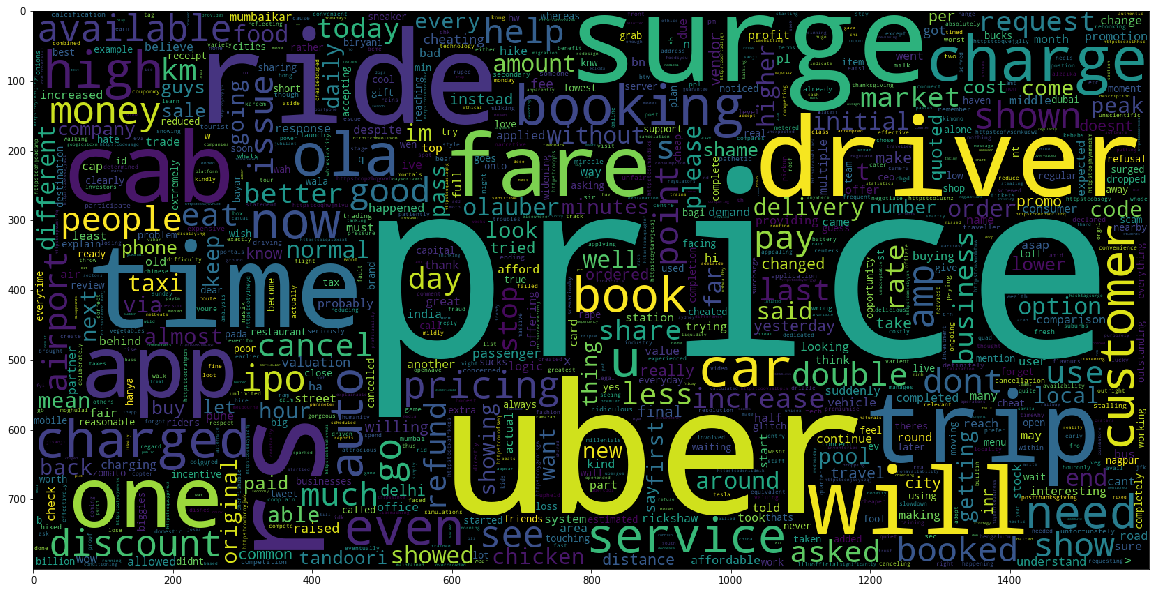

In [89]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.3, random_state = 71)
print('Data Split done.')

Data Split done.


In [93]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [94]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 134
Wall time: 53.3 ms


In [95]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [96]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 1496


In [97]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (114, 60)
X_test.shape : (49, 60)


In [98]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (1496, 100)


In [99]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [100]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Conv1D(100, 10, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [101]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 100)           149600    
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 400)           481600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 400)           961600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 400)           961600    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 400)           961600    
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 100)           400100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)           

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.4, random_state=101)

### Model Training

In [68]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=10)

Epoch 1/10
10/10 [==============================] - 0s 18ms/step - loss: 1.1430 - accuracy: 0.8247 - val_loss: 0.2320 - val_accuracy: 0.9091
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2564 - accuracy: 0.9485 - val_loss: 0.2580 - val_accuracy: 0.9394
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2588 - accuracy: 0.9588 - val_loss: 0.2262 - val_accuracy: 0.9545
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1356 - accuracy: 0.9897 - val_loss: 0.1794 - val_accuracy: 0.9545
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0686 - accuracy: 1.0000 - val_loss: 0.2461 - val_accuracy: 0.9242
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0948 - accuracy: 0.9897 - val_loss: 0.1932 - val_accuracy: 0.9242
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.1954 - val_accuracy: 0.9242
Epoch 8/10
10

### Performance Metrics And Accuracy

In [69]:
y_pred=model.predict_classes(X_test)

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
confusion_matrix(y_test,y_pred)

array([[19,  5],
       [ 0, 42]], dtype=int64)

In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9242424242424242

In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       0.89      1.00      0.94        42

    accuracy                           0.92        66
   macro avg       0.95      0.90      0.91        66
weighted avg       0.93      0.92      0.92        66

